# 01 Pages per protocol

In [1]:
import re
import datetime
from glob import iglob
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.shell import sqlContext

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Sep  7 2019 18:27:02)
SparkSession available as 'spark'.


## Load the data

In [2]:
def loadData(path):
    frames = []
    for file in iglob(path, recursive=True):
        crawl = re.findall(r'/(\d{4}-\d{2})/', file)
        date = datetime.datetime.strptime(crawl[0] + "-1", "%Y-%W-%w")
        frame = sqlContext.read.parquet(file).toPandas()
        frame['date'] = date
        frames.append(frame)
    data = pd.concat(frames, ignore_index=True).set_index('date').sort_index()
    return data.loc[data['protocol'] == 'https']
    
data = loadData('../data/sri/*/reports/01_pages_per_protocol/')
top1m = loadData('../data/sri/*/reports/01_pages_per_protocol_top1m/')
top1k = loadData('../data/sri/*/reports/01_pages_per_protocol_top1k/')

## Display the data

In [3]:
data

,protocol,number,total,percentage
date,,,,
2016-05-02,https,127605935,1337194450,9.54
2017-02-27,https,737722125,3084165319,23.92
2017-08-21,https,779988216,3280080910,23.78
2018-02-26,https,982101726,3488463319,28.15
2018-08-20,https,1058539043,2686323358,39.40
2019-03-04,https,1395619439,2913733422,47.90
2019-09-02,https,1738143610,2954836069,58.82


## Plot the data

### Chrome HTTP warning release date

```
Release: 2018-07-24
Version: 68.0.3440
Warning: HTTP sites marked as "not secure".
Source: https://en.wikipedia.org/wiki/Google_Chrome_version_history
```

### Firefox HTTP warning release date

```
Release: 2017-03-07
Version: 52
Source: https://en.wikipedia.org/wiki/Firefox_version_history
```

### Safari HTTP warning release date

```
Release: 2018-07-09
Version: 11.1.2
Source: https://en.wikipedia.org/wiki/Safari_version_history
```

### Let's encrypt release date

```
Launch: 2016-04-12
Source: https://en.wikipedia.org/wiki/Let%27s_Encrypt
```

### ACME
```
v1 launch: April 12, 2016
v2 launch: March 13, 2018
Source: 
```

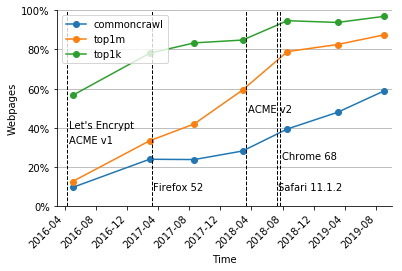

In [6]:
ax = data['percentage'].plot(legend="True", style='o-')

top1m['percentage'].plot(legend="True", style='o-')
top1k['percentage'].plot(legend="True", style='o-')

plt.legend(["commoncrawl", "top1m", "top1k"], loc='upper left')

plt.xticks(rotation=45)
plt.xlim(datetime.date(2016, 3, 1), datetime.date(2019, 10, 1))
plt.ylim(0, 100)
plt.xlabel('Time')
plt.ylabel('Webpages')

ax.set_yticklabels(['{:,.0%}'.format(x / 100) for x in ax.get_yticks()])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid()

# Let's encrypt ACME v1
acmev1 = datetime.date(2016, 4, 12)
plt.text(acmev1 + datetime.timedelta(days=5), 40, "Let's Encrypt")
plt.text(acmev1 + datetime.timedelta(days=5), 32, "ACME v1")
plt.axvline(x=acmev1, color='k', linestyle='--', linewidth=1)

## Firefox 52
plt.text(datetime.date(2017, 3, 7) + datetime.timedelta(days=5), 8, "Firefox 52")
plt.axvline(x=datetime.date(2017, 3, 7), color='k', linestyle='--', linewidth=1)

# ACME v2
acmev2 = datetime.date(2018, 3, 13)
plt.text(acmev2 + datetime.timedelta(days=5), 48, "ACME v2")
plt.axvline(x=acmev2, color='k', linestyle='--', linewidth=1)

## Safari 11.1.2
plt.text(datetime.date(2018, 7, 9) + datetime.timedelta(days=5), 8, "Safari 11.1.2")
plt.axvline(x=datetime.date(2018, 7, 9), color='k', linestyle='--', linewidth=1)

## Chrome 68
plt.text(datetime.date(2018, 7, 24) + datetime.timedelta(days=5), 24, "Chrome 68")
plt.axvline(x=datetime.date(2018, 7, 24), color='k', linestyle='--', linewidth=1)

## Edge does not provide specific warning

plt.savefig('01_pages_per_protocol.pdf', bbox_inches = 'tight')

In [5]:
out = open("01_pages_per_protocol.tex", 'w')
    
lastCrawl = data.reset_index()[-1:]

out.write("\def\\CCUrlN{\\num{" + ("%0.2f" % lastCrawl['total']) + "}}\n")
out.write("\def\\CCUrlHttpsN{\\num{" + ("%0.2f" % lastCrawl['number']) + "}}\n")
out.write("\def\\CCUrlHttpsP{\\num{" + ("%0.2f" % lastCrawl['percentage']) + "}\%}\n")

out.close()
